In [57]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import MinMaxScaler

In [103]:
df = pd.read_csv(r'./train.csv')
pd.options.display.max_columns = 999

In [104]:
df_corr = pd.DataFrame(abs(df.corr()['SalePrice']).sort_values(ascending=False))
df_corr = df_corr[df_corr > .1].T
df_corr

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
SalePrice,1.0,0.790972,0.708584,0.640383,0.623385,0.613792,0.605971,0.560604,0.533682,0.522877,0.507015,0.486264,0.477411,0.466828,0.386783,0.351896,0.328881,0.319193,0.31598,0.284626,0.263843,0.227551,0.214281,0.168272,0.135979,0.128695,0.111378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols = df_corr.columns[:2]
df.fillna(0)

def min_max_scale(data):
  scaler = MinMaxScaler()
  scaler.fit(data)
  return scaler.transform(data)

X = df[cols]
y = pd.DataFrame(X.pop('SalePrice'))

ymax = y.max()

y = min_max_scale(y)
X = min_max_scale(X)

In [116]:
class NN:
  def __init__(self, X, y, hidden_layers=None, loss_function='mae', bias=1):
    self.X = np.array(X)
    self.y = np.array(y)
    self.y = self.y.reshape(self.y.shape[0], 1)
    self.loss_function = loss_function
    self.bias = bias
    if hidden_layers:
      self.generate_layers(hidden_layers)
  
  
  def generate_layers(self, hidden_layers):
    self.hidden_layers = hidden_layers
    np.random.seed(1)
    self.schema = [X.shape[1]] + hidden_layers + [self.y.shape[1]]
    self.schema_len = range(len(self.schema[:-1]))
    for i, layer in enumerate(self.schema[:-1]):
      setattr(self, f'W{i}', np.random.uniform(-1, 1, (layer, self.schema[i+1])))
      if i != len(self.schema_len) - 1:
        setattr(self, f'b{i}', np.full((1, self.schema[i+1]), self.bias))
  
      
  # sigmoid
  def nonlin(self, x, deriv=False):
    if(deriv==True):
      return x * (1 - x)
    return 1/ (1 + np.exp(-x))
  
  
  def forward(self, X=None):
    if X:
      self.l0 = np.array(X)
    else:
      self.l0 = self.X
    for i in self.schema_len:
      l, W = (getattr(self, j) for j in f'l{i} W{i}'.split())
      if i != len(self.schema_len)-1:
        b = getattr(self, f'b{i}')
        setattr(self, f'l{i+1}', self.nonlin(l.dot(W) + b))
      else:
        setattr(self, f'l{i+1}', self.nonlin(l.dot(W)))
    return getattr(self, f'l{len(self.schema_len)}')
    
  
  def loss(self, error):
    loss_dict = {
      'mae': lambda x: np.mean(abs(x)),
      'mse': lambda x: np.mean(x**2),
      'hmse': lambda x: np.mean((x**2)*.5),
    }
    loss_function = loss_dict[self.loss_function]
    return loss_function(error)
    
    
  def backward(self):
    for i in reversed(self.schema_len):   # calculation loss
      i += 1
      l = getattr(self, f'l{i}')
      if i == len(self.schema_len):
        error = self.y - l
        self.error = self.loss(error)
      else:
        delta, W = (getattr(self, j) for j in f'l{i}delta W{i}'.split())
        error = delta.dot(W.T)
      setattr(self, f'l{i-1}delta', error * self.nonlin(l, deriv=True))
      
    for i in reversed(self.schema_len):   # adjusting weights
      l, W, delta = (getattr(self, j) for j in f'l{i} W{i} l{i}delta'.split())
      delta = l.T.dot(delta)
      setattr(self, f'W{i}', W + delta)

    
    
  def train(self, epochs=1000, print_nth_epoch=100):
    for j in range(epochs):
      self.forward()
      self.backward()
      if print_nth_epoch and not j % print_nth_epoch:
        print(f'Error: {self.error}')
       
      
  def predict(self, x):
    return self.forward(x)
  
  
  def genetic_alogrithm(self, population_size=30, mutation_rate=0.05, algorithm_epochs=30, nn_epochs=400):
    
    def make_new_generation(fitness):
      new_generation = []
      new_gen_labels = []
      for i in range(len(fitness)//2):
        parent = [int(j) for j in fitness[i][0].split()]
        child1 = [] # increment layers
        child2 = [] # decrement layers
        for layer_number in parent:
          if random.random() > mutation_rate: # change the number of neurons in each layer
            child1.append(layer_number + 1)
            if layer_number > 1:
              child2.append(layer_number - 1)
        if random.random() > mutation_rate: # add or remove a layer
          child1.append(random.choice(range(1,12)))
          if len(child2) > 2:
            child2.pop()
        for child in [child1, child2]:
          new_generation.append(child)
          new_gen_labels.append(str(child)[1:-1].replace(',', ''))
      return new_generation, new_gen_labels
    
    def create_initial_population():
      organisms = []
      organism_labels = []
      for i in range(population_size):
        organisms.append(np.random.choice(range(2,50), (random.choice(range(2,10)), )).tolist())
        organism_labels.append(str(organisms[i]).replace(',', '')[1:-1])
      return organisms, organism_labels
          
    def find_fitness(organisms, organism_labels):
      fitness = []
      for organism, organism_label in zip(organisms, organism_labels):
        self.generate_layers(organism)
        self.train(nn_epochs, None)
        fitness.append([organism_label, self.error])
      fitness = sorted(fitness, key=lambda x: x[1])
      fittest_list.append(fitness[0])
      return fitness
    
    fittest_list = [] # list of fittest organisms to be plotted.
    
    organisms, organism_labels = create_initial_population()
    fitness = find_fitness(organisms, organism_labels)
    
    for _ in range(algorithm_epochs):
      organisms, organism_labels = make_new_generation(fitness)
      fitness = find_fitness(organisms, organism_labels)
      
    self.x_labels = [label for label, x in fittest_list]
    self.x_fitness = [x for label, x in fittest_list]
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax = plt.plot(self.x_fitness)
    plt.xticks(range(len(self.x_labels)), self.x_labels, rotation=90)
    plt.show()
  
  def find_best_bias(self, bias_range=np.arange(-5,5,.1), nn_epochs=400):
    score = []
    for i in bias_range:
      self.generate_layers(self.hidden_layers)
      self.bias = i
      self.train(nn_epochs, None)
      score.append(self.error)
      
    self.bias_score = list(sorted(zip(score, bias_range), key=lambda x: x[0]))
    self.bias_score_df = pd.DataFrame(nn.bias_score, columns=['Error', 'Bias'])
    
    fig, ax = plt.subplots(figsize=(15,5))
    plt.xticks([x for x in range(len(bias_range))[::2]], [str(round(x,2)) for x in bias_range[::2]], rotation=90)
    ax = plt.plot(score)
    plt.show()

In [117]:
nn2 = NN(X, y, [50, 100], loss_function='mae', bias=-3.8)
nn2.train(1000, 200)

Error: 0.2859320827346648
Error: 0.04957120863310882
Error: 0.048182975185484186
Error: 0.04715900593267621
Error: 0.04626043228370228


In [125]:
0.04682828509329459 * ymax

35355.355245437415

In [121]:
nn1 = NN(X, y, [50, 100], loss_function='mae', bias=-4.2)
nn1.train(1000, 200)

Error: 0.29160873721547187
Error: 0.05023386849636441
Error: 0.04897227183654856
Error: 0.0475970082730742
Error: 0.04682828509329459


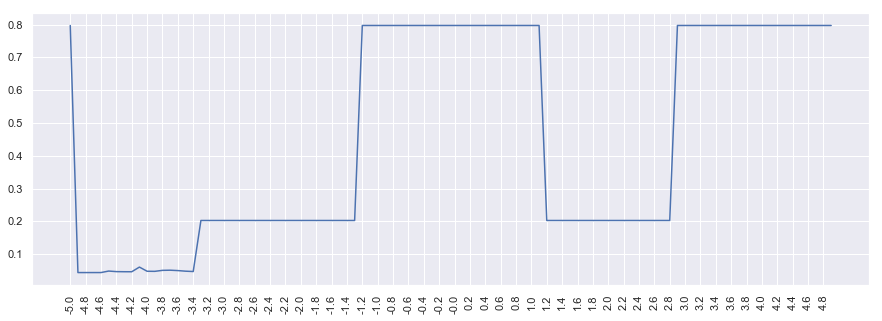

In [102]:
nn = NN(X, y, [50, 100])
nn.find_best_bias()

In [124]:
nn.bias_score_df[:5]

AttributeError: 'NN' object has no attribute 'bias_score_df'

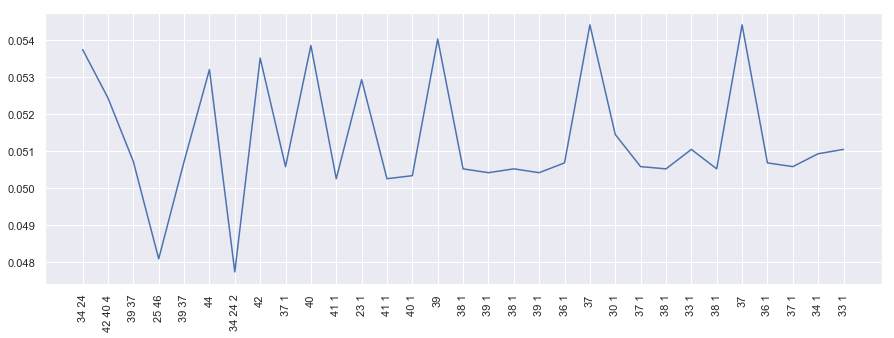

In [123]:
nn = NN(X, y, bias=-4.6)
nn.genetic_alogrithm(20, nn_epochs=300)

In [8]:
place = 11

prediction = nn.predict([X[place]]).reshape(1,)[0] * ymax
actual = y[place] * ymax

print(f'Error: {round(abs(prediction - actual))}')

Error: 201129.0
